In [ ]:
#Подключение библиотек и скриптов

import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

import warnings
warnings.filterwarnings('ignore')


In [ ]:
#Пути к директориям и файлам

TRAIN_DATASET_PATH = 'https://raw.githubusercontent.com/Strukov0107/Python-for-Data-Science/main/Data_For_Project/train.csv'
TEST_DATASET_PATH = 'https://raw.githubusercontent.com/Strukov0107/Python-for-Data-Science/main/Data_For_Project/test.csv'
SAMPLE_SUBMITION_PATH = 'https://raw.githubusercontent.com/Strukov0107/Python-for-Data-Science/main/Data_For_Project/sample_submission.csv'

#Загрузка данных
#для начала проанализируем тренировочные данные

df_train = pd.read_csv(TRAIN_DATASET_PATH)
#df_test = pd.read_csv(TEST_DATASET_PATH)

#покажем тренировочные данные
df_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855


In [ ]:
df_train.dtypes   #покажем название колонок и тип данных в них

#Описание датасета

#Id - идентификационный номер квартиры
#DistrictId - идентификационный номер района
#Rooms - количество комнат
#Square - площадь
#LifeSquare - жилая площадь
#KitchenSquare - площадь кухни
#Floor - этаж
#HouseFloor - количество этажей в доме
#HouseYear - год постройки дома
#Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
#Social_1, Social_2, Social_3 - социальные показатели местности
#Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
#Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
#Price - цена квартиры

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [ ]:
#заменим категорийные значения колонок с буквенных значений на цифровые
binary_to_numbers = {'A': 0, 'B': 1}

df_train['Ecology_2'] = df_train['Ecology_2'].replace(binary_to_numbers)
df_train['Ecology_3'] = df_train['Ecology_3'].replace(binary_to_numbers)
df_train['Shops_2'] = df_train['Shops_2'].replace(binary_to_numbers)

In [ ]:
#избавимся от пропусков данных в столбце Healthcare_1

# создадим df_drop, по которой будем потом соединять файлы,  
df_drop = df_train[['Id', 'LifeSquare']]

target_name = 'Healthcare_1'
df_train.drop(['LifeSquare'], axis=1, inplace=True)

#df_drop.head()

#введём новую колонку 'nan' по которой разделим файл на две части
df_train['nan'] = 0
df_train.loc[df_train['Healthcare_1'].isna(), 'nan'] =1

#один файл будет с значениями Healthcare_1, а другой с пропусками
df_test1 = df_train[df_train['nan'] ==1]
df_train1 = df_train[df_train['nan'] ==0]

X = df_train1.drop(columns=[target_name])
y = df_train1[target_name]

In [ ]:
#обучим модель  Random Forest №1

#создадим модель
model_rf1 = RandomForestRegressor(random_state=21, criterion='mse')

#обучение модели на полных данных
model_rf1.fit(X, y)


RandomForestRegressor(criterion='mse', random_state=21)

In [ ]:
df_test1 = df_test1.drop(columns=target_name)
#предсказание данных
df_test1[target_name] = model_rf1.predict(df_test1)

df_test1 = df_test1.drop(columns='nan')

#переведём полученные значения Healthcare_1 в целые числа
df_test1[target_name] = df_test1[target_name].apply(int)
#df_test1.head()

#объединим полученные результаты в общий файл с данными
df_train1 = df_train1.drop(columns='nan')
df2_merged = pd.merge(df_test1, df_train1, how='outer') 
df3_merged = pd.merge(df_drop, df2_merged, how='left')

#расположим столбцы в первоначальном порядке
df_train = df3_merged.reindex(columns=['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'])

In [ ]:
#избавимся от пропусков данных в столбце LifeSquare

# создадим df_drop, по которой будем потом соединять файлы,  
df_drop = df_train[['Id', 'Healthcare_1']]

target_name = 'LifeSquare'
df_train.drop(['Healthcare_1'], axis=1, inplace=True)

#введём новую колонку 'nan' по которой разделим файл на две части
df_train['nan'] = 0
df_train.loc[df_train['LifeSquare'].isna(), 'nan'] =1

#один файл будет с значениями LifeSquare, а другой с пропусками
df_test1 = df_train[df_train['nan'] ==1]
df_train1 = df_train[df_train['nan'] ==0]

X = df_train1.drop(columns=[target_name])
y = df_train1[target_name]

#обучим модель  Random Forest №2

#создадим модель
model_rf2 = RandomForestRegressor(random_state=21, criterion='mse')

#обучение модели на полных данных
model_rf2.fit(X, y)

df_test1 = df_test1.drop(columns=target_name)
#предсказание данных
df_test1[target_name] = model_rf2.predict(df_test1)

df_test1 = df_test1.drop(columns='nan')

#объединим полученные результаты в общий файл с данными
df_train1 = df_train1.drop(columns='nan')
df2_merged = pd.merge(df_test1, df_train1, how='outer') 
df3_merged = pd.merge(df_drop, df2_merged, how='left')

#расположим столбцы в первоначальном порядке
df_train = df3_merged.reindex(columns=['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'])

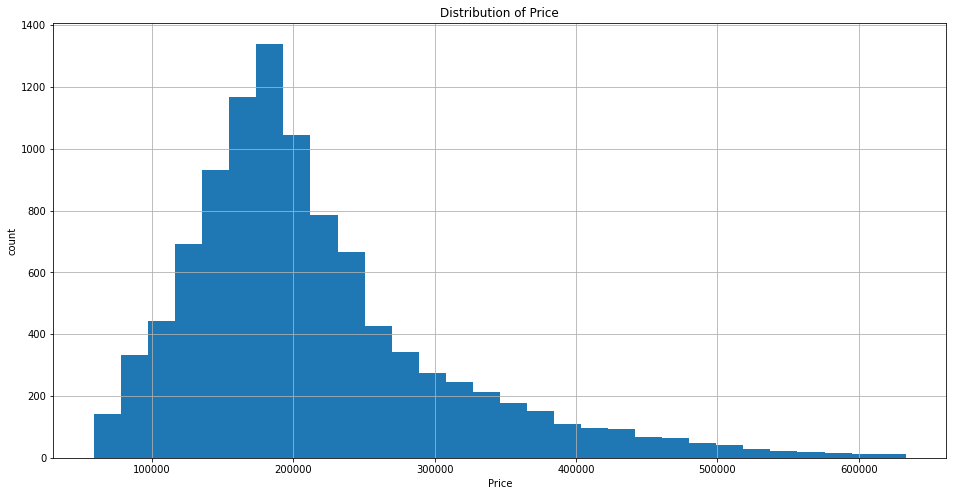

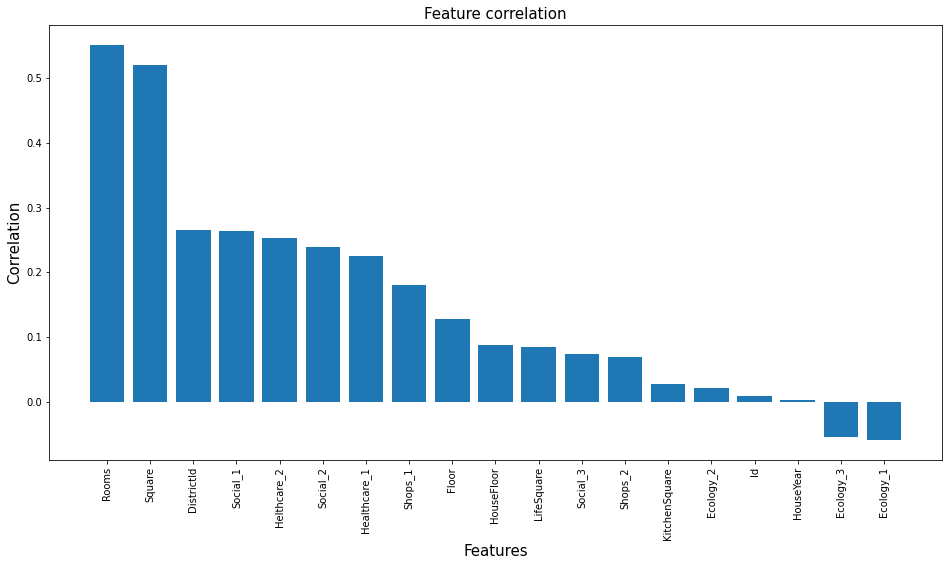

In [ ]:
#Посмотрим на распределение цен
plt.figure(figsize = (16, 8))

df_train['Price'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Distribution of Price')
plt.show()

#посмотрим на зависимость цен на квартиры от других параметров

correlation = df_train.corrwith(df_train['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

In [ ]:
# Удалим  "Id", "Rooms", "Ecology_2"

df_train = df_train.drop(columns='Id')
df_train = df_train.drop(columns='Rooms')
df_train = df_train.drop(columns='Ecology_2')

In [ ]:
#посмотрим данные Square - площадь
df_train['Square'].value_counts()

#на первый взгляд всё нормально
df_train['Square'].sort_values().unique()

array([  1.13685878,   1.98894272,   2.37724759, ..., 409.42518143,
       604.70597195, 641.06519275])

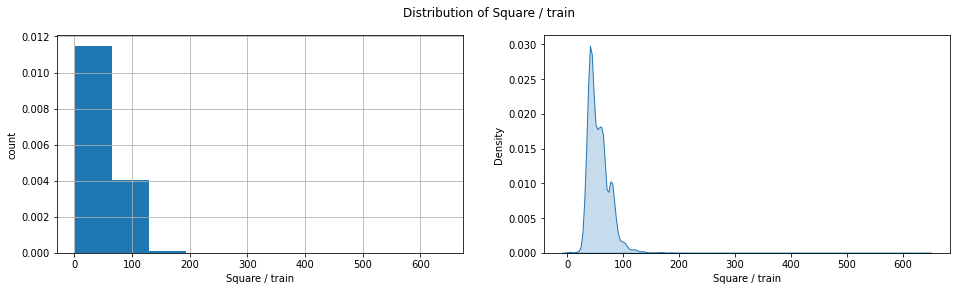

In [ ]:
plt.figure(figsize = (16, 4))

plt.subplot(121)
df_train['Square'][:10000].hist(density=True)
plt.ylabel('count')
plt.xlabel('Square / train')

plt.subplot(122)
sns.kdeplot(df_train['Square'][:10000], shade=True, legend=False)
plt.xlabel('Square / train')

plt.suptitle('Distribution of Square / train')
plt.show()

#

#plt.figure(figsize = (16, 4))

#plt.subplot(121)
#df_test['Square'][10000:].hist(density=True)
#plt.ylabel('count')
#plt.xlabel('Square / test')

#plt.subplot(122)
#sns.kdeplot(df_test['Square'][10000:], shade=True, legend=False)
#plt.xlabel('Square / test')

#plt.suptitle('Distribution of Square / test')
#plt.show()

площадь квартиры менее 10 и более 400 м2 будем считать выбросами и заменим на медианы

In [ ]:
#присвоим выбросам значения медиан
Square_median = df_train['Square'].median()
df_train.loc[df_train['Square'] < 10, 'Square'] = Square_median
df_train.loc[df_train['Square'] > 400, 'Square'] = Square_median

df_train['Square'].sort_values().unique()

array([ 13.78486476,  16.11715428,  16.54724199, ..., 200.33453939,
       212.93236105, 275.64528408])

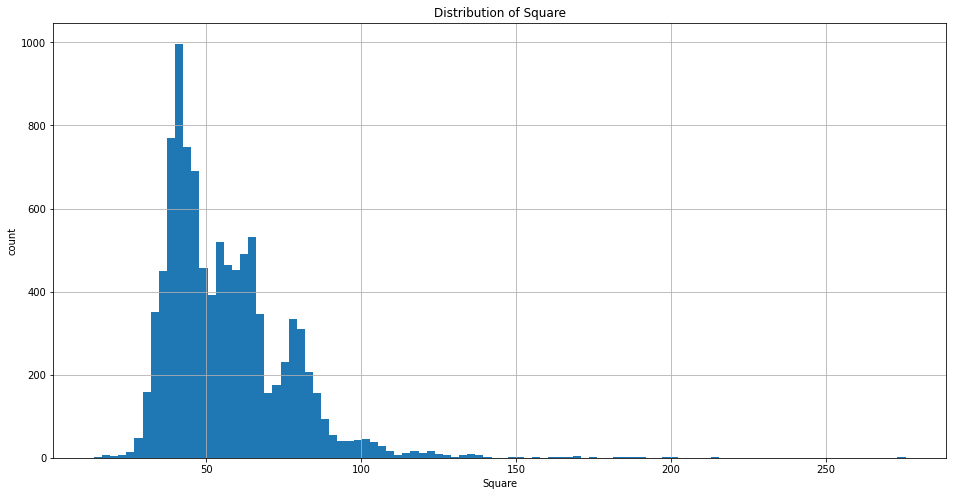

In [ ]:
plt.figure(figsize = (16, 8))

df_train['Square'].hist(bins=100)
plt.ylabel('count')
plt.xlabel('Square')

plt.title('Distribution of Square')
plt.show()

In [ ]:
#посмотрим данные KitchenSquare - площадь кухни
df_train['KitchenSquare'].value_counts()
df_train['KitchenSquare'].sort_values().unique()
#есть выбросы

array([0.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 5.000e+00,
       6.000e+00, 7.000e+00, 8.000e+00, 9.000e+00, 1.000e+01, 1.100e+01,
       1.200e+01, 1.300e+01, 1.400e+01, 1.500e+01, 1.600e+01, 1.700e+01,
       1.800e+01, 1.900e+01, 2.000e+01, 2.100e+01, 2.200e+01, 2.300e+01,
       2.500e+01, 2.600e+01, 2.700e+01, 2.900e+01, 3.000e+01, 3.100e+01,
       3.200e+01, 3.500e+01, 3.600e+01, 3.700e+01, 3.900e+01, 4.000e+01,
       4.100e+01, 4.200e+01, 4.300e+01, 4.800e+01, 5.100e+01, 5.300e+01,
       5.400e+01, 5.800e+01, 6.000e+01, 6.200e+01, 6.300e+01, 6.600e+01,
       7.200e+01, 7.300e+01, 7.500e+01, 7.800e+01, 8.400e+01, 9.600e+01,
       1.120e+02, 1.230e+02, 1.970e+03, 2.014e+03])

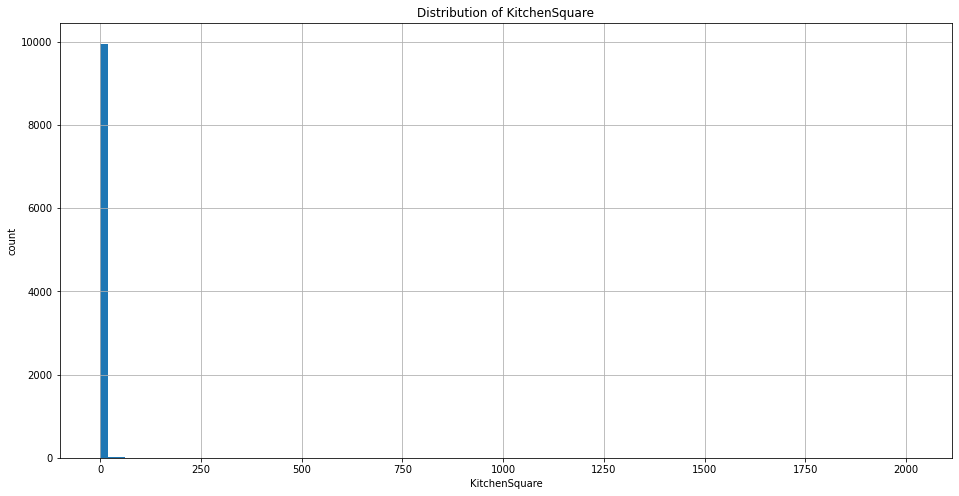

In [ ]:
plt.figure(figsize = (16, 8))

df_train['KitchenSquare'].hist(bins=100)
plt.ylabel('count')
plt.xlabel('KitchenSquare')

plt.title('Distribution of KitchenSquare')
plt.show()

площадь кухни менее 10 и более 200 м2 будем считать выбросами и заменим на медианы

In [ ]:
#присвоим выбросам значения медиан
KitchenSquare_median = df_train['KitchenSquare'].median()
df_train.loc[df_train['KitchenSquare'] < 10, 'KitchenSquare'] = KitchenSquare_median
df_train.loc[df_train['KitchenSquare'] > 200, 'KitchenSquare'] = KitchenSquare_median

df_train['KitchenSquare'].sort_values().unique()

array([  6.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,
        20.,  21.,  22.,  23.,  25.,  26.,  27.,  29.,  30.,  31.,  32.,
        35.,  36.,  37.,  39.,  40.,  41.,  42.,  43.,  48.,  51.,  53.,
        54.,  58.,  60.,  62.,  63.,  66.,  72.,  73.,  75.,  78.,  84.,
        96., 112., 123.])

In [ ]:
#посмотрим данные Floor - этаж
df_train['Floor'].value_counts()

#на первый взгляд всё нормально

4     949
5     876
3     872
6     802
7     759
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
22     54
24     53
25     34
23     25
26     18
27      5
28      3
32      2
31      1
33      1
42      1
37      1
Name: Floor, dtype: int64

In [ ]:
#посмотрим данные HouseYear - год постройки дома
df_train['HouseYear'].value_counts()

#есть странные данные
df_train['HouseYear'].sort_values().unique()

#присвоим выбросам значения медиан
HouseYear_median = df_train['HouseYear'].median()

df_train.loc[df_train['HouseYear'] > 2021, 'HouseYear'] = HouseYear_median

df_train['HouseYear'].sort_values().unique()

array([1910, 1912, 1914, 1916, 1917, 1918, 1919, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942,
       1947, 1948, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [ ]:
# проверим есть ли пустые данные

df_train.isna().sum()

DistrictId       0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [ ]:
#сформируем массив X
X = df_train.drop(columns='Price')

X.info()
#пропущенных данных нет

#сформируем массив y

y = df_train['Price']

y

#разобьём датафреймы на тренировочные и тестовые

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Square         10000 non-null  float64
 2   LifeSquare     10000 non-null  float64
 3   KitchenSquare  10000 non-null  float64
 4   Floor          10000 non-null  int64  
 5   HouseFloor     10000 non-null  float64
 6   HouseYear      10000 non-null  int64  
 7   Ecology_1      10000 non-null  float64
 8   Ecology_3      10000 non-null  int64  
 9   Social_1       10000 non-null  int64  
 10  Social_2       10000 non-null  int64  
 11  Social_3       10000 non-null  int64  
 12  Healthcare_1   10000 non-null  float64
 13  Helthcare_2    10000 non-null  int64  
 14  Shops_1        10000 non-null  int64  
 15  Shops_2        10000 non-null  int64  
dtypes: float64(6), int64(10)
memory usage: 1.3 MB


In [ ]:
#создадим модель линейной регрессии
#from sklearn.linear_model import LinearRegression
#lr = LinearRegression()

#обучение модели
#lr.fit(X_train, y_train)

#y_pred = lr.predict(X_test)   #предсказание данных
#check_test = pd.DataFrame({'y_test': y_test,
 #                         'y_pred': y_pred.flatten()},
  #                        columns=['y_test', 'y_pred'])

#check_test.head(10)     #сравним тестовую выборку и предсказанные данные

#Вычислим R2 полученных предказаний
#r2_score(y_test, y_pred)

In [ ]:
#обучим модель  Random Forest

#создадим модель
#model_rf = RandomForestRegressor(n_estimators=1000,
 #                             max_depth=12,
  #                            random_state=42)

#обучение модели
#model_rf.fit(X_train, y_train)

#y_pred = model_rf.predict(X_test)   #предсказание данных
#check_test = pd.DataFrame({'y_test': y_test,
 #                         'y_pred': y_pred.flatten()},
  #                        columns=['y_test', 'y_pred'])

#check_test.head(10)     #сравним тестовую выборку и предсказанные данные


#Вычислим R2 полученных предказаний
#r2_score(y_test, y_pred)

In [ ]:
#Gradient Boosting Regressor model fit and predict for train dataset

gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)
#обучение модели
gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_test)   #предсказание данных

check_test = pd.DataFrame({'y_test': y_test,
                          'y_pred': y_pred.flatten()},
                          columns=['y_test', 'y_pred'])

check_test.head(10)     #сравним тестовую выборку и предсказанные данные


#Вычислим R2 полученных предказаний
r2_score(y_test, y_pred)


0.7657420962183931

In [ ]:
#XGBR model model fit and predict for train dataset

#gb_model = xgb.XGBRegressor(colsample_bytree=0.4445, 
 #                           learning_rate=0.015, max_depth=6,
  #                           min_child_weight=0.1, 
   #                          n_estimators=1000,
    #                         reg_lambda=0.6,
     #                        random_state =7)

   #обучение модели                          
#gb_model.fit(X_train, y_train)


#y_pred = gb_model.predict(X_test)   #предсказание данных

#check_test = pd.DataFrame({'y_test': y_test,
 #                         'y_pred': y_pred.flatten()},
   #                       columns=['y_test', 'y_pred'])

#check_test.head(10)     #сравним тестовую выборку и предсказанные данные


#Вычислим R2 полученных предказаний
#r2_score(y_test, y_pred)


Первая модель дала результат 0.48 (LinearRegression)

Вторая модель дала результат 0.73 ( RandomForestRegressor)

Вывод:

в данному случае более эффективна модель RandomForestRegressor

Если удалить строки с комнатами = 0, 10 и 19, то получим -587.1949 и 0.7243
Удалять строки с номерами комнат НЕЖЕЛАТЕЛЬНО!!!

Если удалить строки с комнатами = 0, присвоить 1, а те кторые >6 присвоить значение медианы, то получим 0.5109 и 0.7324
ОТЛИЧНЫЙ ВАРИАНТ!!!

Если в строки с комнатами = 0, присвоить 1, а те которые >7 присвоить значение медианы, то получим 0.5091 и 0.7324
ПРЕДЫДУЩИЙ ВАРИАНТ ЛУЧШЕ !!!

После замены данных в трёх столбцах (А и В) на 0 и 1 соответственно, то получим 0.5171 и 0.7328
ОТЛИЧНЫЙ ВАРИАНТ!!!

Если убрать выбросы в столбце с данными по  площади (от 10 до 150), то получим 0.5430 и 0.72706
Трогать данные по  площади НЕЖЕЛАТЕЛЬНО!!!

Если убрать выбросы в столбце с данными по  площади (от 10 до 200), то получим 0.54456 и 0.73015
Трогать данные по  площади НЕЖЕЛАТЕЛЬНО!!!

Если убрать выбросы в столбце с данными по  площади (от 10 до 400), то получим 0.5439 и 0.73185
Трогать данные по  площади НЕЖЕЛАТЕЛЬНО!!!

Если убрать выбросы в столбце с данными по дате постройки дома (>2021), то получим 0.5447 и 0.73197
ОТЛИЧНЫЙ ВАРИАНТ!!!

Если удалить строки с отсутствующими данными, то получим -0.4893 и 0.69389
НЕЖЕЛАТЕЛЬНО!!!

Если удалить выбросы в колонке Жилая площадь, то получим 0.5447 и 0.73197
ОТЛИЧНЫЙ ВАРИАНТ!!!

Добавил ещё две новые модели. В итоге:
LinearRegression   0.5447
RandomForest       0.7319
GradientBoosting   0.7616
XGBR model         0.7564

После удаления столбца Id. В итоге:
LinearRegression   0.5449
RandomForest       0.7330
GradientBoosting   0.7670
XGBR model         0.7542

После удаления столбцы HouseYear. В итоге:
LinearRegression   0.5441
RandomForest       0.7293
GradientBoosting   0.7569
XGBR model         0.7431

Не трогаем данные в столбце Square. В итоге:
LinearRegression   0.5166
RandomForest       0.7336
GradientBoosting   0.7639
XGBR model         0.7563

Не удаляем столбцы HouseYear. В итоге:
LinearRegression   0.5166
RandomForest       0.7336
GradientBoosting   0.7639
XGBR model         0.7563

Нормализуем значения в столбцах ['Square', 'LifeSquare', 'Social_2']. В Итоге:
LinearRegression   0.5166
RandomForest       0.7336
GradientBoosting   0.7639
XGBR model         0.7563

Заменим пропущенные данные в LifeSquare Healthcare_1 на соответствующие медианы?НЕЖЕЛАТЕЛЬНО!!!
LinearRegression   0.5151
RandomForest       0.7303
GradientBoosting   0.7617
XGBR model         0.7537

Удалим столбцы KitchenSquare, HouseYear, HouseYear   . В итоге:НЕЖЕЛАТЕЛЬНО!!!
LinearRegression   0.5120
RandomForest       0.7141
GradientBoosting   0.7483
XGBR model         0.7301

С помощью RF найдём пропущенные значения в Healthcare_1   . В итоге:ПОЛОЖИТЕЛЬНЫЙ РЕЗУЛЬТАТ!!!
LinearRegression   0.5193
RandomForest       0.7299
GradientBoosting   0.7584
XGBR model         0.7525

С помощью RF найдём пропущенные значения в LifeSquare     . В итоге:ОТРИЦАТЕЛЬНЫЙ РЕЗУЛЬТАТ!!!
LinearRegression   0.3877
RandomForest       0.7296
GradientBoosting   0.7578
XGBR model         0.7550


Снова пробуем удалить HouseYear     . В итоге:ОТРИЦАТЕЛЬНЫЙ РЕЗУЛЬТАТ!!!
LinearRegression   0.3877
RandomForest       0.7266
GradientBoosting   0.7475
XGBR model         0.7432

Снова пробуем удалить Id     . В итоге:ПОЛОЖИТЕЛЬНЫЙ РЕЗУЛЬТАТ!!!
LinearRegression   0.3911
RandomForest       0.7300
GradientBoosting   0.7606
XGBR model         0.7534

убрать выбросы HouseYear     . В итоге:ПОЛОЖИТЕЛЬНЫЙ РЕЗУЛЬТАТ!!!
LinearRegression   0.3942
RandomForest       0.7302
GradientBoosting   0.7613
XGBR model         0.7533

убрать выбросы Rooms     . В итоге:ОТРИЦАТЕЛЬНЫЙ РЕЗУЛЬТАТ!!!
LinearRegression   0.4223
RandomForest       0.7302
GradientBoosting   0.7606
XGBR model         0.7539

удалить Rooms     . В итоге:ПОЛОЖИТЕЛЬНЫЙ РЕЗУЛЬТАТ!!!
LinearRegression   0.3856
RandomForest       0.7321
GradientBoosting   0.7617
XGBR model         0.7564

Отказываемся от модели линейной регрессии

убрать выбросы Square. В итоге:ПОЛОЖИТЕЛЬНЫЙ РЕЗУЛЬТАТ!!!
RandomForest       0.7308
GradientBoosting   0.7633
XGBR model         0.7568

удалить Social_1     . В итоге:ОТРИЦАТЕЛЬНЫЙ РЕЗУЛЬТАТ!!!
RandomForest       0.7286
GradientBoosting   0.7625
XGBR model         0.7557

удалить Ecology_2     . В итоге:ПОЛОЖИТЕЛЬНЫЙ РЕЗУЛЬТАТ!!!
RandomForest       0.7304
GradientBoosting   0.7649
XGBR model         0.7566

удалить KitchenSquare     . В итоге:ОТРИЦАТЕЛЬНЫЙ РЕЗУЛЬТАТ!!!
RandomForest       0.7271
GradientBoosting   0.7645
XGBR model         0.7551

убрать выбросы LifeSquare.     . В итоге:ОТРИЦАТЕЛЬНЫЙ РЕЗУЛЬТАТ!!!
RandomForest       0.7308
GradientBoosting   0.7642
XGBR model         0.7565

убрать выбросы KitchenSquare.     . В итоге:ПОЛОЖИТЕЛЬНЫЙ РЕЗУЛЬТАТ!!!
RandomForest       0.7300
GradientBoosting   0.7657
XGBR model         0.7571

8. Прогнозирование на тестовом датасете

Выполнить для тестового датасета те же этапы обработки и построeния признаков
Не потерять и не перемешать индексы от примеров при построении прогнозов
Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)

In [ ]:
#загрузим датасет по которому будем делать предсказания

df_test = pd.read_csv(TEST_DATASET_PATH)
df_test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B


In [ ]:
#загрузим форму для предсказаний

submit = pd.read_csv(SAMPLE_SUBMITION_PATH)
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [ ]:
#заменим категорийные значения колонок с буквенных значений на цифровые
binary_to_numbers = {'A': 0, 'B': 1}

df_test['Ecology_2'] = df_test['Ecology_2'].replace(binary_to_numbers)
df_test['Ecology_3'] = df_test['Ecology_3'].replace(binary_to_numbers)
df_test['Shops_2'] = df_test['Shops_2'].replace(binary_to_numbers)
#X_test = df_test

In [ ]:
#избавимся от пропусков данных в столбце Healthcare_1

# создадим df_drop, по которой будем потом соединять файлы,  
df_drop_test = df_test[['Id', 'LifeSquare']]

target_name = 'Healthcare_1'
df_test.drop(['LifeSquare'], axis=1, inplace=True)

#df_drop.head()

#введём новую колонку 'nan' по которой разделим файл на две части
df_test['nan'] = 0
df_test.loc[df_test['Healthcare_1'].isna(), 'nan'] =1

#один файл будет с значениями Healthcare_1, а другой с пропусками
df_test1 = df_test[df_test['nan'] ==1]
df_train1 = df_test[df_test['nan'] ==0]

X = df_train1.drop(columns=[target_name])
y = df_train1[target_name]

#обучим модель  Random Forest

#создадим модель
model_rf = RandomForestRegressor(random_state=21, criterion='mse')

#обучение модели на полных данных
model_rf.fit(X, y)

df_test1 = df_test1.drop(columns=target_name)
#предсказание данных
df_test1[target_name] = model_rf.predict(df_test1)

df_test1 = df_test1.drop(columns='nan')

#переведём полученные значения Healthcare_1 в целые числа
df_test1[target_name] = df_test1[target_name].apply(int)
#df_test1.head()

#объединим полученные результаты в общий файл с данными
df_train1 = df_train1.drop(columns='nan')
df2_merged = pd.merge(df_test1, df_train1, how='outer') 
df3_merged = pd.merge(df_drop_test, df2_merged, how='left')

#расположим столбцы в первоначальном порядке
df_test = df3_merged.reindex(columns=['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2'])


In [ ]:
#избавимся от пропусков данных в столбце LifeSquare

# создадим df_drop, по которой будем потом соединять файлы,  
df_drop_test = df_test[['Id', 'Healthcare_1']]

target_name = 'LifeSquare'
df_test.drop(['Healthcare_1'], axis=1, inplace=True)

#введём новую колонку 'nan' по которой разделим файл на две части
df_test['nan'] = 0
df_test.loc[df_test['LifeSquare'].isna(), 'nan'] =1

#один файл будет с значениями LifeSquare, а другой с пропусками
df_test1 = df_test[df_test['nan'] ==1]
df_train1 = df_test[df_test['nan'] ==0]

X = df_train1.drop(columns=[target_name])
y = df_train1[target_name]

#обучим модель  Random Forest

#создадим модель
model_rf = RandomForestRegressor(random_state=21, criterion='mse')

#обучение модели на полных данных
model_rf.fit(X, y)

df_test1 = df_test1.drop(columns=target_name)
#предсказание данных
df_test1[target_name] = model_rf.predict(df_test1)

df_test1 = df_test1.drop(columns='nan')

#переведём полученные значения Healthcare_1 в целые числа
#df_test1[target_name] = df_test1[target_name].apply(int)
#df_test1.head()

#объединим полученные результаты в общий файл с данными
df_train1 = df_train1.drop(columns='nan')
df2_merged = pd.merge(df_test1, df_train1, how='outer') 
df3_merged = pd.merge(df_drop_test, df2_merged, how='left')

#расположим столбцы в первоначальном порядке
df_test = df3_merged.reindex(columns=['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2'])

In [ ]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,24,4378,0,1036.0,1,1,1
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,2,629,1,404.0,0,0,0
2,960,27,2.0,59.463678,42.824735,9.0,19,19.0,1977,0.211401,1,1,9,1892,0,538.0,0,1,1
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,2,475,0,207.0,0,0,1
4,746,74,1.0,53.837056,35.575769,1.0,8,17.0,1977,0.309479,1,1,35,7715,4,990.0,0,6,1


In [ ]:
#Проверим  пропущенныe данные

df_test.isna().sum()



#X_test.info()
#пропущенных данных нет

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

In [ ]:
# Удалим  "Id", "Rooms", "Ecology_2"

df_test = df_test.drop(columns='Id')
df_test = df_test.drop(columns='Rooms')
X_test = df_test.drop(columns='Ecology_2')




In [ ]:
predictions = gb_model.predict(X_test)
predictions

array([168702.77817024, 130422.82641047, 140854.66660188, ...,
       153817.71172726, 195823.78029488, 316547.89292219])

In [ ]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,168702.778170
1,5925,130422.826410
2,960,140854.666602
3,3848,107151.724400
4,746,216292.266552


In [ ]:
submit.to_csv('rf_submit.csv', index=False)

NEAR MISS Project

In [ ]:
from pandas.core.arrays.categorical import factorize_from_iterables
import pandas as pd
import numpy as np
import difflib

#загрузим данные о всех старых НМ
df1 = pd.read_csv('https://raw.githubusercontent.com/Strukov0107/TerVer_Ana_MatStat/master/NMproject/CSV_1.csv')

#загрузим данные о всех новых НМ за последний месяц
df2 = pd.read_csv('https://raw.githubusercontent.com/Strukov0107/TerVer_Ana_MatStat/master/NMproject/CSV_2.csv')

#df1
#df2

#Определим количество записей в обоих массивах данных
df1_len= len(df1)
df2_len= len(df2)

#df1_len, df2_len

def similarity(s1, s2):     #вводим функцию сравнения
  normalized1 = s1.lower()
  normalized2 = s2.lower()
  matcher = difflib.SequenceMatcher(None, normalized1, normalized2)
  return matcher.ratio()

criteria = 0.69   #точность совпадений 0.89
counter = 0       #счётчик количества совпадений
site_name = str() #название цеха

for i in range (1, df2_len, 1): #перебираем каждый элемент второго массива
  value2 = df2.iat[i, 4]
  data_2 = df2.iat[i, 2]
  code_2 = df2.iat[i, 3]  #код цеха из файла №2
  if code_2 == 1:
    site_name = str('МехОП')
  elif code_2 == 2:
    site_name = str('ПГП')  
  elif code_2 == 3:
    site_name = str('СОП')
  elif code_2 == 4:
    site_name = str('МетОП')
  elif code_2 == 5:
    site_name = str('ПЭАРЗиА')
  elif code_2 == 6:
    site_name = str('ПРУ')
  elif code_2 == 7:
    site_name = str('ПМК')
  elif code_2 == 8:
    site_name = str('ПМЗиPVbox')
  elif code_2 == 9:
    site_name = str('ПТПиА')
  elif code_2 == 10:
    site_name = str('РТ1')
  elif code_2 == 11:
    site_name = str('РТ2')
  elif code_2 == 12:
    site_name = str('РТ3')
  elif code_2 == 13:
    site_name = str('РТ (ОГМ,ОГЭ,ОВЛ)')
  elif code_2 == 14:
    site_name = str('ЖДЦ и группа по управлению НТМЦ и МО')
  elif code_2 == 15:
    site_name = str('АТЦ')
  elif code_2 == 16:
    site_name = str('Управление складской логистики и отдел отгрузки')
  elif code_2 == 17:
    site_name = str('ИЦ')
  elif code_2 == 18:
    site_name = str('ЦНТ')
  elif code_2 == 19:
    site_name = str('Дирекция по качеству')
  elif code_2 == 20:
    site_name = str('ДТО')
  elif code_2 == 21:
    site_name = str('Кластер оборудования СН (ШЭ)')

  is_printed = False

  for j in range (1, df1_len, 1): #перебираем каждый элемент первого массива
    #value1 = df1.iat[j, 4]
    code_1 = df1.iat[j, 3]  #код цеха из файла №1

    if code_2 != code_1:
      pass
    else:
      value1 = df1.iat[j, 4]
      data_1 = df1.iat[j, 2]
      sim_value = similarity(value2, value1)  #сравниваем записи первого и второго массива
      if sim_value > criteria:
        if not is_printed:
          print (' ')
          print (f'совпадения по цеху:  {site_name} ')
          print(f'{df2.iat[i, 0]:<7d} {data_2}    {value2}')
          is_printed = True
        else:
          pass

        print(f'{df1.iat[j, 0]:<7d} {data_1}    {value1}')
        counter += 1

print (' ')
print (' ')
print ('проверка завершена')
print ('количество выявленных совпадений', counter)


 
совпадения по цеху:  МетОП 
12      11.05.22    сломанный поддон с металлом
5797    29.07.20    Сломанный поддон на участке.
 
совпадения по цеху:  МетОП 
15      26.05.22    На первом этаже в душевой провис потолок.
12194   07.02.22    В раздевалке на первом этаже в душевой провисает потолок.
 
совпадения по цеху:  МетОП 
16      24.05.22    В комнате приема пищи развалилась розетка.
9541    27.10.21    В комнате приема пищи была неисправна розетка.
 
совпадения по цеху:  ПЭАРЗиА 
20      04.05.22    На участке трещина в полу.
1654    27.03.19    На участке не ровные полы.
5934    29.01.20    На участке огромная трещина в полу.
5991    18.02.20    На участке большая трещина на полу.
 
совпадения по цеху:  ПМЗиPVbox 
23      11.05.22    На участке сборки модулей в проходе лежал упаковочный материал.
6888    01.06.20    На проходе лежал упаковочный материал
 
совпадения по цеху:  ПМЗиPVbox 
26      16.05.22    Споткнулся об прокладочный материал (брус).
2378    27.03.19    Шел по прох

In [ ]:
#Анализ ключевых слов в выборке

import pandas as pd
#import numpy as np

#загрузим данные о всех старых НМ
df1 = pd.read_csv('https://raw.githubusercontent.com/Strukov0107/TerVer_Ana_MatStat/master/NMproject/CSV_1.csv')

#Определим количество записей в массивe данных
df1_len= len(df1)

#откроем файл для записи
f1 = open('/content/sample_data/ниамис прожект.txt', 'w')
#существующие ф файле данные при открытии на запись стираются автоматически

probel = ' '          #константа=пробел
site_number = 13     #код подразделения
for i in range (1, df1_len, 1): #перебираем каждый элемент первого массива

  if df1.iat[i, 3] == site_number:
    value1 = str(df1.iat[i, 4])     #переводим в тип переменных строка
    f1.write(value1)                #и записываем в файл
    f1.write(probel)        #будем разделять строки пробелом

# в конце файл необходимо закрыть
f1.close()

f1 = open('/content/sample_data/ниамис прожект.txt', 'r', encoding="utf-8")
# выведем все содержимоe

print(f1.read())
f1.close()


Выход из пролета завален упаковкой Течь ванны №2 Торчит болит из порога на входе в зону раздевалок Не плотно закрывается аварийные ограждения зоны разгрузки поперечного раскроя Перевозка трансформаторов на эл. Тележке с поврежденными колесами. Вероятность опрокидывания бака из-за вибрации тележки ГАК мостово крана находится в зоне проезда погрузчиков на малой высоте при выезде в буферную зону происходит пробуксовка погрузчика из-за гололеда  опасность получить трамву сотрудникам возле модуля кладовщиков лежат бруски  торчат гвозди на поддоне складируется бумага ЭКМ-100  обмотана полиэтиленом  часть которого свисает с поддона на крыше  свисает снег и сосульки перед выгрузкой рулонов со сталью обнаружен дефект стропы Складирование поддонов выше 1 метра Розливы трансформаторного масла Разлет дроби при работе установки Розлив дистиллированной воды из емкости для сбора воды. Упаковочный полиэтилен лежит на полу в проходе Плохо закреплена дверь шкафа электроавтомата на таре весом 26 кг оторв

длинна текста:  12289
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
выход из пролета завален упаковкой течь ванны № торчит болит из порога на входе в зону раздевалок не плотно закрывается аварийные ограждения зоны разгрузки поперечного раскроя перевозка трансформаторов на эл тележке с поврежденными колесами вероятность опрокидывания бака изза вибрации тележки гак мостово крана находится в зоне проезда погрузчиков на малой высоте при выезде в буферную зону происходит пробуксовка погрузчика изза гололеда  опасность получить трамву сотрудникам возле модуля кладовщиков лежат бруски  торчат гвозди на поддоне складируется бумага экм  обмотана полиэтиленом  часть которого свисает с поддона на крыше  свисает снег и сосульки перед выгрузкой рулонов со сталью обнаружен дефект стропы складирование поддонов выше  метра розливы трансформаторного масла разлет дроби при работе установки розлив дистиллированной воды из емкости для сбора воды упаковочный полиэтилен лежит на полу в проходе плохо закреплена дверь шка

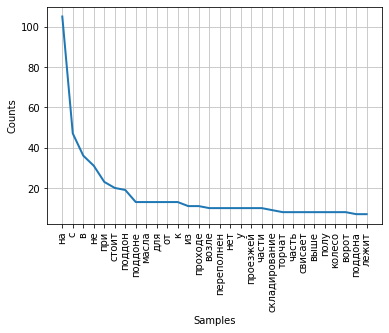

LookupError: ignored

In [ ]:
f1 = open('/content/sample_data/ниамис прожект.txt', 'r', encoding="utf-8")
# выведем первые 142 символа (если параметр не указывать, выведется все содержимое)
#print(f1.read())

text = f1.read()
print('длинна текста: ', len(text))

#Предварительная обработка (препроцессинг) текста
#Для начала переведём символы в единый регистр, например, нижний:
text = text.lower()

#Используем стандартный набор символов пунктуации из модуля string:
import string
print(string.punctuation)
spec_chars = string.punctuation + '\n\xa0«»\t—…' 
text = "".join([ch for ch in text if ch not in spec_chars])

def remove_chars_from_text(text, chars):
    return "".join([ch for ch in text if ch not in chars])

text = remove_chars_from_text(text, spec_chars)
text = remove_chars_from_text(text, string.digits)

print(text)

#Токенизация текста
import nltk
nltk.download('punkt')

import nltk
from nltk.tokenize import word_tokenize

text_tokens = word_tokenize(text, language="russian")

len(text_tokens)
text_tokens[:10]

import nltk
text = nltk.Text(text_tokens)
print(type(text))
text[:10]

from nltk.probability import FreqDist
fdist = FreqDist(text)

fdist.most_common(5)

fdist.plot(30,cumulative=False)

from nltk.corpus import stopwords


russian_stopwords = stopwords.words("russian")

russian_stopwords.extend(['это', 'нею'])

fdist_sw.most_common(10)

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

text_raw = " ".join(text)

wordcloud = WordCloud().generate(text_raw)



f1.close()

# HW


##Урок 2. Масштабирование признаков. L1- и L2-регуляризация. Стохастический градиентный спуск


1.Сгенерировать датасет при помощи sklearn.datasets.make_regression и обучить линейную модель при помощи градиентного спуска и стохастического градиентного спуска. 
Построить графики среднеквадратичной ошибки от числа итераций для обоих методов на одном рисунке, сделать выводы о разнице скорости сходимости каждого из методов.

массив coef
[40.71064891  6.60098441] 




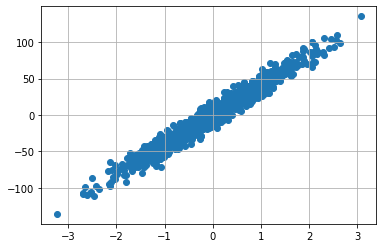

In [ ]:
#Подключение библиотек и скриптов
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

%matplotlib inline

#реализуем функцию, вычисляющую средне-квадратичное отклонение
def calc_mse(y, y_pred):      
    err = np.mean((y - y_pred)**2) # <=> 1/n * np.sum((y_pred - y)**2)
    return err



mse1_list = []         #координаты ошибки для постороения графика            (х)
itr1_list = []         #координаты кол-ва итераций для постороения графика   (у)
# Метод градиентного спуска
def eval_GD(X, y, iterations, eta=1e-3):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations + 1):
        y_pred = np.dot(X, w)
        err = calc_mse(y, y_pred)
        w -= eta * (1/n * 2 * np.dot(X.T, (y_pred - y)))
        if i % (iterations / 10) == 0:
            print(f'{i}: weights={w}, MSE={err:.3f}')
            itr1_list.append(i)
            mse1_list.append(err)
    return w


mse2_list = []         #координаты ошибки для постороения графика            (х)
itr2_list = []         #координаты кол-ва итераций для постороения графика   (у)
# SGD - стохастический градиентный спуск
def eval_SGD(X, y, iterations, eta=1e-4):
    np.random.seed(42)
    w = np.random.randn(X.shape[1]) # начальное приближение весов
    n = X.shape[0] # число наблюдений
    for i in range(1, iterations + 1):
        err = calc_mse(y, np.dot(X, w))
        # генерируем случайный индекс объекта выборки
        ind = np.random.randint(n)
        y_pred = np.dot(X[ind], w)
        w -= eta * (2 * np.dot(X[ind].T, (y_pred - y[ind])))
        if i % (iterations / 10) == 0:
            print(f'{i}: weights={w}, MSE={err:.3f}')
            itr2_list.append(i)
            mse2_list.append(err)
    return w, err


mse3_list = []         #координаты ошибки для постороения графика            (х)
itr3_list = []         #координаты кол-ва итераций для постороения графика   (у)
# mini-batch градиентный спуск
def eval_mbGD(X, y, iterations, batch=3, eta=1e-4):
    np.random.seed(42)
    w = np.random.randn(X.shape[1]) # начальное приближение весов
    n = X.shape[0] # число наблюдений
    n_batch = n // batch # число батчей
    if n % batch != 0:
        n_batch += 1
    print('Количество батчей - ', n_batch)
    for i in range(1, iterations + 1):
        err = calc_mse(y, np.dot(X, w))
        for b in range(n_batch):
            start_ = batch * b
            end_ = batch * (b + 1)
            X_batch = X[start_ : end_, :]
            y_batch = y[start_ : end_]
            y_pred = np.dot(X_batch, w)
            w -= eta * (2/len(y_batch) * np.dot(X_batch.T, (y_pred - y_batch)))
        if i % (iterations / 10) == 0:
            print(f'{i}: weights={w}, MSE={err:.3f}')
            itr3_list.append(i)
            mse3_list.append(err)
    return w, err


#Сгенерируем датасет
X_, y_, coef = datasets.make_regression(n_samples=1000,
                                        n_features=2,
                                        n_informative=2,
                                        n_targets=1,
                                        noise=5,
                                        bias=0,
                                        coef=True,
                                        random_state=42)
#print(f'массив X\n{X_} \n\n')
#print(f'массив y\n{y_} ')
print(f'массив coef\n{coef} \n\n')

plt.scatter(X_[:, 0], y_);
plt.grid()

In [ ]:
%%time
print(f'метод градиентного спуска')
print(eval_GD(X_, y_, iterations=40000, eta=1e-4))

метод градиентного спуска
4000: weights=[21.62794093  3.7714828 ], MSE=376.852
8000: weights=[31.70415416  5.44912077], MSE=104.003
12000: weights=[36.50919643  6.1673524 ], MSE=42.285
16000: weights=[38.80070817  6.4740497 ], MSE=28.310
20000: weights=[39.89358176  6.60462803], MSE=25.143
24000: weights=[40.41482313  6.6600334 ], MSE=24.425
28000: weights=[40.66343805  6.6834495 ], MSE=24.262
32000: weights=[40.78202401  6.6933002 ], MSE=24.225
36000: weights=[40.83859005  6.69742161], MSE=24.216
40000: weights=[40.86557323  6.69913475], MSE=24.214
[40.86557323  6.69913475]
CPU times: user 1.33 s, sys: 13.6 ms, total: 1.35 s
Wall time: 1.81 s


In [ ]:
%%time
print(f'метод стохастического градиентного спуска')
print(eval_SGD(X_, y_, iterations=40000, eta=1e-4)) 

метод стохастического градиентного спуска
4000: weights=[22.0455786   3.99966229], MSE=360.629
8000: weights=[31.84270357  5.37373229], MSE=101.841
12000: weights=[36.73003428  6.14596504], MSE=40.606
16000: weights=[38.92412235  6.45759313], MSE=27.854
20000: weights=[39.974816    6.60759713], MSE=24.999
24000: weights=[40.46734308  6.65783426], MSE=24.380
28000: weights=[40.69853495  6.65982249], MSE=24.248
32000: weights=[40.89245447  6.68172329], MSE=24.214
36000: weights=[40.85285618  6.68693084], MSE=24.215
40000: weights=[40.77363662  6.72001432], MSE=24.227
(array([40.77363662,  6.72001432]), 24.226588354723813)
CPU times: user 2.4 s, sys: 18.7 ms, total: 2.42 s
Wall time: 3.58 s


In [ ]:
%%time
print(f'метод mini-batch градиентного спуска')
print(eval_mbGD(X_, y_, iterations=400, batch=10, eta=1e-4))

метод mini-batch градиентного спуска
Количество батчей -  100
40: weights=[21.62794762  3.77105092], MSE=390.071
80: weights=[31.70394435  5.4483626 ], MSE=106.997
120: weights=[36.50877793  6.16638862], MSE=42.966
160: weights=[38.80013954  6.47296716], MSE=28.466
200: weights=[39.89291727  6.60348031], MSE=25.179
240: weights=[40.41410129  6.65885109], MSE=24.433
280: weights=[40.66268328  6.68224926], MSE=24.264
320: weights=[40.78125087  6.69209083], MSE=24.225
360: weights=[40.83780686  6.69620766], MSE=24.216
400: weights=[40.86478463  6.69791851], MSE=24.214
(array([40.86478463,  6.69791851]), 24.214279332862738)
CPU times: user 415 ms, sys: 5.88 ms, total: 421 ms
Wall time: 423 ms


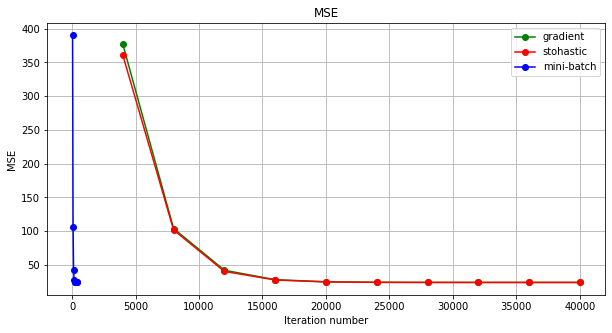

In [ ]:
# Визуализируем изменение значения среднеквадратичной ошибки от числа итераций
# для каждого метода


plt.figure(figsize=(10, 5))
plt.plot(itr1_list, mse1_list,  'go-', label=r'gradient')
plt.plot(itr2_list, mse2_list, 'ro-', label=r'stohastic')
plt.plot(itr3_list, mse3_list, 'bo-', label=r'mini-batch')
plt.title('Зависимость MSE от числа итераций для разных методов')
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.grid()
plt.legend()

Для наглядности построим отдельно построим график для 1 и 2 методов.
Изменим шаг обучения и количество итераций.

100: weights=[7.32874893 1.16801485], MSE=1103.189
200: weights=[13.00512448  2.22541594], MSE=767.897
300: weights=[17.72134432  3.08125022], MSE=536.838
400: weights=[21.63983474  3.77385273], MSE=377.594
500: weights=[24.89554186  4.33428243], MSE=267.836
600: weights=[27.60058142  4.78770076], MSE=192.180
700: weights=[29.84810175  5.15448943], MSE=140.027
800: weights=[31.71549299  5.45115674], MSE=104.072
900: weights=[33.26705326  5.69107223], MSE=79.283
1000: weights=[34.55620366  5.88506234], MSE=62.191
[34.55620366  5.88506234]
100: weights=[5.65425267 1.36197629], MSE=1205.412
200: weights=[12.7105185   3.55875223], MSE=777.747
300: weights=[17.03707268  4.31522315], MSE=557.260
400: weights=[22.08826107  5.2663299 ], MSE=354.413
500: weights=[25.87193649  5.6555326 ], MSE=234.136
600: weights=[28.44101069  5.83399449], MSE=168.474
700: weights=[30.47041536  5.98949961], MSE=126.357
800: weights=[32.21255052  6.06519403], MSE=94.853
900: weights=[33.73922351  6.1450052 ], MS

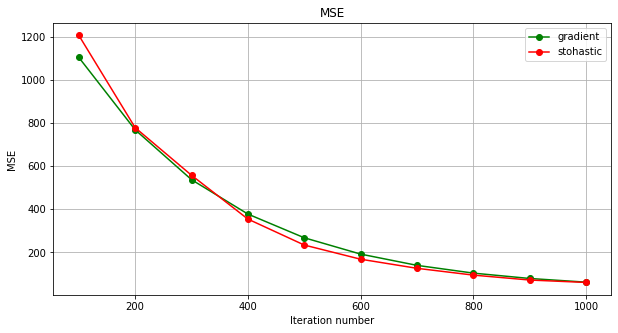

In [ ]:
x1 = eval_GD(X_, y_, iterations=1000, eta=1e-3)
x1 = eval_SGD(X_, y_, iterations=1000, eta=1e-3)

plt.figure(figsize=(10, 5))
plt.plot(itr1_list, mse1_list,  'go-', label=r'gradient')
plt.plot(itr2_list, mse2_list, 'ro-', label=r'stohastic')
#plt.plot(itr3_list, mse3_list, 'bo-', label=r'mini-batch')
plt.title('MSE')
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.grid()
plt.legend()

## ВЫВОД:

1. При использовании алгоритма градиентного спуска минимальное значение средне-квадратичного отклонения = 24.214 достигается за 40 000 итераций и 1.81 секунды;

2. При использовании стохастического градиентного спуска минимальное значение средне-квадратичного отклонения = 24.214  достигается за 32 000 итераций и 5.58 секунды;
  Т.е. количество итерации меньше.
  
3. При использовании алгоритма mini-batch градиентного спуска минимальное значение средне-квадратичного отклонения = 24.214  достигается за 400 итераций и 0.42 секунды.
  Т.е. количество итераций и время в 10 раз меньше, чем в первых двух случаях.
  В данном случае этот алгоритм самый эффективный.

2.[*] Добавить в алгоритм градиентного спуска L1 регуляризацию. 
Сравнить влияние коэффициентов регуляризации L1 и L2 на величину весов для примера из урока (лучше графически).

In [ ]:
#Добавим регуляризацию в алгоритмы градиентного спуска

#   L1 - регуляризация
def eval_model_reg1(X, y, iterations, eta=1e-4, lambda_=1e-4, verbose=False):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations + 1):
        y_pred = np.dot(X, w)
        err = calc_mse(y, y_pred)
        w -= eta * (1/n * 2 * np.dot(X.T, (y_pred - y)) + lambda_ * abs(w))
        if verbose and i % (iterations / 10) == 0:
            print(f'{i}: weights={w}, MSE={err:.3f}')
    return w

#   L2 - регуляризация
def eval_model_reg2(X, y, iterations, eta=1e-4, lambda_=1e-4, verbose=False):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations + 1):
        y_pred = np.dot(X, w)
        err = calc_mse(y, y_pred)
        w -= eta * (1/n * 2 * np.dot(X.T, (y_pred - y)) + lambda_ * (w**2))
        if verbose and i % (iterations / 10) == 0:
            print(f'{i}: weights={w}, MSE={err:.3f}')
    return w


In [ ]:
w1_list = []
w2_list = []
l_list = []

for l in np.logspace(start=-4, stop=2, num=30):
    l_list.append(l)
    w1_new = eval_model_reg1(X_, y_, iterations=1000, eta=1e-2, lambda_=l)
    w1_list.append(w1_new)
    w2_new = eval_model_reg2(X_, y_, iterations=1000, eta=1e-2, lambda_=l)
    w2_list.append(w2_new)


weights1 = np.array(w1_list)
weights2 = np.array(w2_list)


In [ ]:
weights1

In [ ]:
weights2

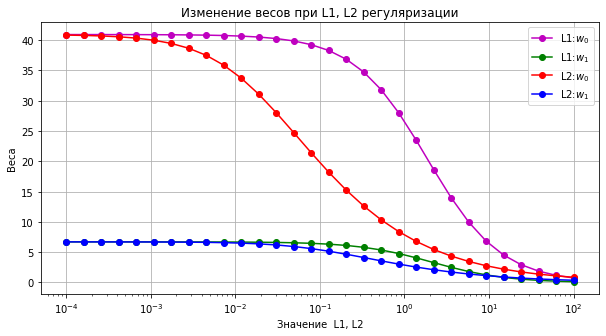

In [ ]:
plt.figure(figsize=(10, 5))
plt.xscale('log')
plt.plot(l_list, weights1[:, 0], 'mo-', label=r'L1:$w_0$')
plt.plot(l_list, weights1[:, 1], 'go-', label=r'L1:$w_1$')
plt.plot(l_list, weights2[:, 0], 'ro-', label=r'L2:$w_0$')
plt.plot(l_list, weights2[:, 1], 'bo-', label=r'L2:$w_1$')
plt.title('Изменение весов при L1, L2 регуляризации')
plt.xlabel('Значение  L1, L2')
plt.ylabel('Веса')
plt.grid()
plt.legend();

In [ ]:
#Подключение библиотек и скриптов
import numpy as np
import matplotlib.pyplot as mpl

def calc_mse(y, y_pred):      #вычисляет средне-квадратичное отклонение
    err = np.mean((y - y_pred)**2) # <=> 1/n * np.sum((y_pred - y)**2)
    return err

def funct_1(X, y, W, alpha, k):
  for i in range(k):
      y_pred = np.dot(W, X)
      err = calc_mse(y, y_pred)
      for j in range(W.shape[0]):
          W[j] -= alpha * (1/n * 2 * np.sum(X[j] * (y_pred - y)))
      if i % 10 == 0:
          alpha /= 1.1
      if i == (k - 1):      
        print(f'Nunber of Iteration #{k}:  MSE = {round(err,2)}')
      else:
        pass  

def funct_2(X, y, W, alpha, k):
  for i in range(k):
      y_pred = np.dot(W, X)
      err = calc_mse(y, y_pred)
      for j in range(W.shape[0]):
          W[j] -= alpha * (1/n * 2 * np.sum(X[j] * (y_pred - y)))
      if i % 10 == 0:
          alpha /= 1.1
      if i == (k - 1):      
        print(f'Nunber of Iteration #{k}:  MSE = {round(err,2)}')
      else:
        pass 



In [ ]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 5, 3, 0, 5, 10, 1, 2]])

y = [45, 55, 50, 55, 60, 35, 75, 80, 50, 60]



n = X.shape[1]
W = np.array([1, 0.5])

#alpha = 1e-2
#k = 100                 #количество повторений (итераций) при вычислении

for m in range(1, 7):
  W = np.array([1, 0.5])
  alpha = 1 / (10 ** (m/2))
  print(f' \n')
  print(f'Learning rate = {alpha} ')

  for k in range(100, 1001, 100):
    funct_1(X, y, W, alpha, k)

 

Learning rate = 0.31622776601683794 
Nunber of Iteration #100:  MSE = 5.37548810811389e+151
Nunber of Iteration #200:  MSE = inf
Nunber of Iteration #300:  MSE = inf
Nunber of Iteration #400:  MSE = nan
Nunber of Iteration #500:  MSE = nan
Nunber of Iteration #600:  MSE = nan
Nunber of Iteration #700:  MSE = nan
Nunber of Iteration #800:  MSE = nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in multiply
  


Nunber of Iteration #900:  MSE = nan
Nunber of Iteration #1000:  MSE = nan
 

Learning rate = 0.1 
Nunber of Iteration #100:  MSE = 429685.33
Nunber of Iteration #200:  MSE = 43.97
Nunber of Iteration #300:  MSE = 43.97
Nunber of Iteration #400:  MSE = 43.97
Nunber of Iteration #500:  MSE = 43.97
Nunber of Iteration #600:  MSE = 43.97
Nunber of Iteration #700:  MSE = 43.97
Nunber of Iteration #800:  MSE = 43.97
Nunber of Iteration #900:  MSE = 43.97
Nunber of Iteration #1000:  MSE = 43.97
 

Learning rate = 0.03162277660168379 
Nunber of Iteration #100:  MSE = 66.93
Nunber of Iteration #200:  MSE = 44.12
Nunber of Iteration #300:  MSE = 43.97
Nunber of Iteration #400:  MSE = 43.97
Nunber of Iteration #500:  MSE = 43.97
Nunber of Iteration #600:  MSE = 43.97
Nunber of Iteration #700:  MSE = 43.97
Nunber of Iteration #800:  MSE = 43.97
Nunber of Iteration #900:  MSE = 43.97
Nunber of Iteration #1000:  MSE = 43.97
 

Learning rate = 0.01 
Nunber of Iteration #100:  MSE = 313.79
Nunber of 

как мы можем видеть из результатов вычисления, чем больше значение альфа (скорость вычисления),
 тем меньшее количество итераций необходимо выполнить.
Самый лучший результат мы получили при альфа=0.01
При значении =0.3 мы уже получили ошибку, значит оптимальный размер альфа находится в диапазоне 0.3 - 0.01. 
Исследуем этот диапазон более подробно:

In [ ]:
for m in range(31, 0, -1):
  W = np.array([1, 0.5])
  alpha = m/100
  print(f' \n')
  print(f'Learning rate = {alpha} ')

  for k in range(100, 501, 100):
    funct_1(X, y, W, alpha, k)


Просмотрев полученные результаты, мы видим, что быстрее всего работает алгоритм при alpha=0.09.
При значениях alpha больше  0.17  алгоритм уходит в ошибку (отклонение стремится к бесконечности).

Посчитаем количество итераций, необходимое для достижениия требуемой точности результата:


In [ ]:
W = np.array([1, 0.5])
alpha = 0.09
print(f' \n')
print(f'Learning rate = {alpha} ')

for k in range(80, 90, 1):
  funct_1(X, y, W, alpha, k)


 

Learning rate = 0.09 
Nunber of Iteration #80:  MSE = 597869.96
Nunber of Iteration #81:  MSE = 8258001.19
Nunber of Iteration #82:  MSE = 25541621.11
Nunber of Iteration #83:  MSE = 4674275.63
Nunber of Iteration #84:  MSE = 98502.89
Nunber of Iteration #85:  MSE = 282.69
Nunber of Iteration #86:  MSE = 44.04
Nunber of Iteration #87:  MSE = 43.97
Nunber of Iteration #88:  MSE = 43.97
Nunber of Iteration #89:  MSE = 43.97


из расчётов видно, что требуемый результат достигается начиная с 87 повторения

ОТВЕТ:
оптимальные параметри скорости обучения и количества повторов следующие:
alpha=0.09
n=87

*2. В этом коде мы избавляемся от итераций по весам, но здесь есть ошибка, исправьте её.

In [ ]:
#Подключение библиотек и скриптов
import numpy as np

def calc_mse(y, y_pred):      #вычисляет средне-квадратичное отклонение
    err = np.mean((y - y_pred)**2) # <=> 1/n * np.sum((y_pred - y)**2)
    return err


X = np.array([[ 1,  1],
       [ 1,  1],
       [ 1,  2],
       [ 1,  1],
       [ 1,  3],
       [ 1,  0],
       [ 1,  5],
       [ 1, 10],
       [ 1,  1],
       [ 1,  2]])

y = [45, 55, 50, 55, 60, 35, 75, 80, 50, 60]

eta = 1e-2      #шаг обучения

n = X.shape[1]
W = np.array([1, 0.5])

w = np.array([1, 0.5])
for i in range(1001):
    y_pred = np.dot(w, X.T)
    err = calc_mse(y, y_pred)
    w -= (eta * (1/n * 2 * np.dot(X.T, (y_pred - y)))) # ошибка исправлена(дот вместо сумм и запятая в скобках)
    if i % 100 == 0:
        print(i, w, err)

0 [ 6.42 17.31] 3068.75
100 [45.99016051  4.00304145] 36.904373021918474
200 [46.18528317  3.96701056] 36.881378081070125
300 [46.18621997  3.96683757] 36.88137755103261
400 [46.18622447  3.96683674] 36.88137755102042
500 [46.18622449  3.96683673] 36.881377551020414
600 [46.18622449  3.96683673] 36.88137755102039
700 [46.18622449  3.96683673] 36.8813775510204
800 [46.18622449  3.96683673] 36.881377551020414
900 [46.18622449  3.96683673] 36.881377551020414
1000 [46.18622449  3.96683673] 36.8813775510204


*3. Вместо того чтобы задавать количество итераций, задайте условие остановки алгоритма, когда ошибка за итерацию начинает изменяться ниже определённого порога — упрощённый аналог параметра tol в линейной регрессии в sklearn.

In [ ]:
import datetime
d = str(datetime.date.today())
print(d)
x = '2022-06-06'
if x < d :
  print("True")
else:
  print ("false")

2022-06-07
True


In [ ]:
from pandas.core.arrays.categorical import factorize_from_iterables
import pandas as pd
import numpy as np
import datetime

#загрузим данные
df = pd.read_csv('https://raw.githubusercontent.com/Strukov0107/TerVer_Ana_MatStat/master/TestReports%20project/DataSet1.csv')

df


#Определим количество записей в массиве данных
df_len= len(df)


#сегодняшняя дата
data_today = str(datetime.date.today())

#Маркер, равен количеству просроченных документов
marker = 0

print(f' Информация на сегодня {data_today} :   ')
print ('\n')

for i in range (0, df_len, 1): #перебираем каждый элемент массива
  data_1 = df.iat[i, 5]
  data_2 = df.iat[i, 7]  
  if data_today > data_1:
    marker += 1
    value = str(df.iat[i, 1])
    code = str(df.iat[i, 0])
    if data_today > data_2:
      print(f'истёк срок действия протокола № {code}  {value}')
      print (f'указан срок {data_2}  , а сегодня {data_today}')
#      print(type(data_1), type(data_2))
      print ('\n')
    else:
      print (f'скоро истечёт срок действия протокола № {code}  {value}')
      print (f'указан срок {data_2}  , а сегодня {data_today}')
      print ('\n')

print ('\n') 
if marker == 0:
  print (f'На данный момент документов с истёкшим сроком нет')
else:
  print (f' Всего обнаружено {marker} документов')


In [ ]:
import smtplib
#import os

def send_email(message):
  sender = "test-reports_reminder@mail.ru"
  password = "Password_for"

  server = smtplib("smtp.mail.ru", 25)
  server.starttls()

  try:
    server.login(sender, password)
    server.send_email(sender, sender, message)

    return "The message was sent successfully!"
  except Exception as _ex:
    return f'{_ex}\nCheck your login or password please!'

def main():
  message = input("Type your message")
  print(send_email(message=message))
  pass

if __name__ == "__main__":
  main()


Type your messageThe Matrix has you


TypeError: ignored

In [ ]:
import datetime
import telebot
import pandas as pd

token = '5453650676:AAEU6Ypnrnn4PGawR1GC0sAZA-k509OSAbw'

bot = telebot.TeleBot(token)
dkp_chat = -1001446509488   #SESHwork group


#загрузим данные
df = pd.read_csv('https://raw.githubusercontent.com/Strukov0107/TerVer_Ana_MatStat/master/DLP_Birthday_reminder/DKP_employees.csv')

#Определим количество записей в массиве данных
df_len= len(df)


#сегодняшняя дата
data_today = datetime.date.today()
day_today = int(data_today.day)                  #сегодняшний день
month_today = int(data_today.month)              #сегодняшний месяц


for i in range (0, df_len, 1):      #перебираем каждый элемент массива
  data_1 = df.iat[i, 3]
  day_1 = int(data_1[8] + data_1[9])             #день рождения
  month_1 = int(data_1[5] + data_1[6])           #месяц рождения

  if month_today == month_1:
    if day_today == day_1:
      namee = str(df.iat[i, 2])
      telfn = str(df.iat[i, 4])
      bot.send_message(dkp_chat, f'Сегодня  {data_today} день рождения  {namee} телефон {telfn}')
      print(f'Сегодня  {data_today} день рождения  {namee} телефон {telfn}')

bot.polling(none_stop=True, interval = 5)


ModuleNotFoundError: ignored

In [ ]:
mse1_list

[]

In [ ]:
itr1_list.clear()
mse1_list.clear()

##   Урок 4. Алгоритм построения дерева решений

###Задание №1

В коде из методички реализуйте один или несколько критериев останова:

минимальное количество объектов в листе (min_leaf), 

максимальная глубина дерева, 

максимальное количество листьев и т.д. 

Добавьте эти критерии в параметры функции build_tree и проверьте ее работоспособность с помощью визуализации дерева (функция print_tree()).

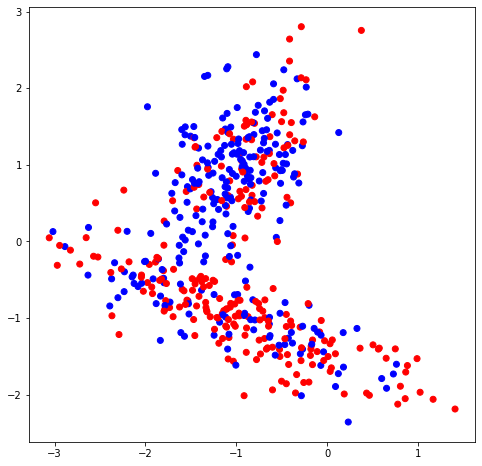

In [70]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(
    n_samples=500,
    n_features=2,
    n_informative=2, 
    n_classes=2,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.75,
    random_state=5
)

# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [71]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле


class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction     

# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity


# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)



# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels


# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)


def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)


def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")


# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0


# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


In [72]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf):
    
    #  обозначим минимальное количество объектов в узле(если не задано, то приравниваем к 1)
    min_leaf = min_leaf if min_leaf else 1
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


# Построение дерева с помощью рекурсивной функции, добавлено ограничение глубины, и минимальное количество элементов в листе:

def build_tree(data, labels, max_depth=None, min_leaf=None):
    
    # Если глубина не задана, будем строить по максимуму
    max_depth=max_depth if max_depth!=None else data.shape[0]*data.shape[1]

    quality, t, index = find_best_split(data, labels, min_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества, или достигли максимальной глубины
    if quality == 0 or max_depth==0 :
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева, уменьшая их глубину
    true_branch = build_tree(true_data, true_labels,max_depth=max_depth-1,min_leaf=min_leaf)
    false_branch = build_tree(false_data, false_labels,max_depth=max_depth-1, min_leaf=min_leaf)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)


# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    classification_data, classification_labels, test_size = 0.3, random_state = 1
)

# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_depth=6, min_leaf=15)

print_tree(my_tree)

Индекс 1
Порог -0.46624201061399206
--> True:
  Индекс 0
  Порог -1.7945477571816848
  --> True:
    Прогноз: 1
  --> False:
    Индекс 0
    Порог -1.1834902220493384
    --> True:
      Прогноз: 0
    --> False:
      Индекс 1
      Порог -1.2659561512192585
      --> True:
        Индекс 0
        Порог 0.04595444880264021
        --> True:
          Индекс 1
          Порог -1.4684500103378144
          --> True:
            Прогноз: 0
          --> False:
            Прогноз: 0
        --> False:
          Прогноз: 0
      --> False:
        Индекс 0
        Порог -0.645018457805447
        --> True:
          Индекс 1
          Порог -0.9370288134393376
          --> True:
            Прогноз: 0
          --> False:
            Прогноз: 0
        --> False:
          Прогноз: 1
--> False:
  Индекс 0
  Порог -0.9820958539320116
  --> True:
    Индекс 0
    Порог -1.6445609784573159
    --> True:
      Индекс 0
      Порог -2.1808550952749775
      --> True:
        Прогноз: 0
    

In [73]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

72.57142857142857

In [74]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

60.66666666666667

Text(0.5, 1.0, 'Test accuracy=60.67')

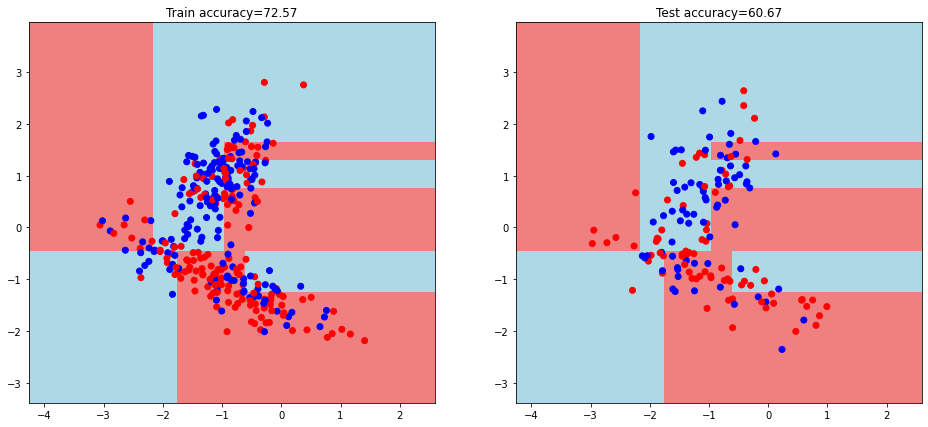

In [75]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

##Урок 5. Случайный лес

###Задание №1

Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками.

Обучить случайный лес из 1, 3, 10, 50, 100 и 200 деревьев (за основу взять реализацию построения этого алгоритма из урока).

Визуализировать их разделяющие линии на графиках (по подобию визуализации деревьев из предыдущего урока, 
необходимо только заменить вызов функции predict на tree_vote).

Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [77]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import train_test_split

import numpy as np

In [78]:
# сгенерируем данные, представляющие собой 1000 объектов с 2-ю признаками

X, y = datasets.make_classification(n_samples=1000,
                           n_features=2, n_informative=2, 
                           n_classes=2, n_redundant=0, 
                           n_clusters_per_class=2, flip_y=0.1, random_state=1)

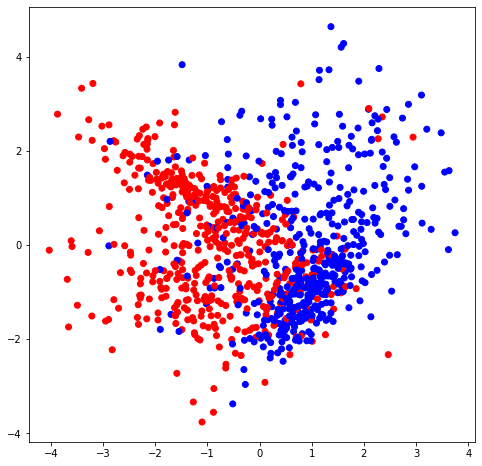

In [79]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])


plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], X)), list(map(lambda x: x[1], X)), 
              c=y, cmap=colors);

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [80]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [81]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

Далее повторим реализацию построения дерева решений из предыдущего урока с 

некоторыми изменениями

In [82]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [84]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

In [85]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [86]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [87]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [88]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объекта
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [89]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [90]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) # список массивов координатных сеток

Теперь добавим функцию формирования случайного леса.


In [91]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [92]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf): 
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [93]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [94]:
predictions = [[1,1,1], [1,0,0], [1,0,1], [0,0,1]]
print(*predictions)
#p = np.array(predictions).T
p = list(zip(*predictions))
print(p)
[max(set(x), key=x.count) for x in p]

[1, 1, 1] [1, 0, 0] [1, 0, 1] [0, 0, 1]
[(1, 1, 1, 0), (1, 0, 0, 0), (1, 0, 1, 1)]


[1, 0, 1]

In [95]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

Далее мы сделаем обычное разбиение выборки на обучающую и тестовую, 
как это делалось ранее. 

Оценить ошибку этого же алгоритма по методу Out-of-Bag будет вашим домашним 
заданием к этому уроку.

In [96]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(X, y, 
                                                      test_size = 0.3,
                                                      random_state = 1)

In [98]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

##Теперь построим несколько случайных лесов с разным количеством деревьев в них.

Построим лес из одного дерева

In [99]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

In [100]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [101]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [102]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 90.429
Точность случайного леса из 1 деревьев на тестовой выборке: 68.667


In [108]:
GLOB=[] #глобальная переменная для сохранения результата

def get_report(train_data, train_labels, test_data, test_labels, n_trees):
    global GLOB
    my_forest=random_forest(train_data, train_labels, n_trees)
    train_answers = tree_vote(my_forest, train_data)
    test_answers = tree_vote(my_forest, test_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')
        
    plt.figure(figsize = (16, 7))
        
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape) # определяем цвета квадратов в сетке
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'N_trees={n_trees}\nTrain accuracy={train_accuracy:.2f}')
        
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'N_trees={n_trees}\nTest accuracy={test_accuracy:.2f}')
        
    GLOB.append([n_trees,train_accuracy,test_accuracy])

Точность случайного леса из 1 деревьев на обучающей выборке: 90.714
Точность случайного леса из 1 деревьев на тестовой выборке: 69.000


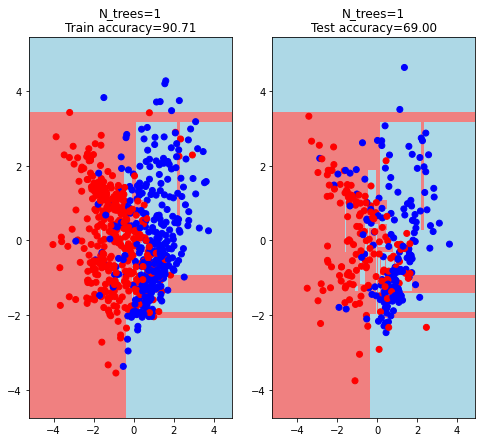

In [114]:
get_report(train_data, train_labels, test_data, test_labels, 1)

Построим лес из трех деревьев

Точность случайного леса из 3 деревьев на обучающей выборке: 95.143
Точность случайного леса из 3 деревьев на тестовой выборке: 76.333


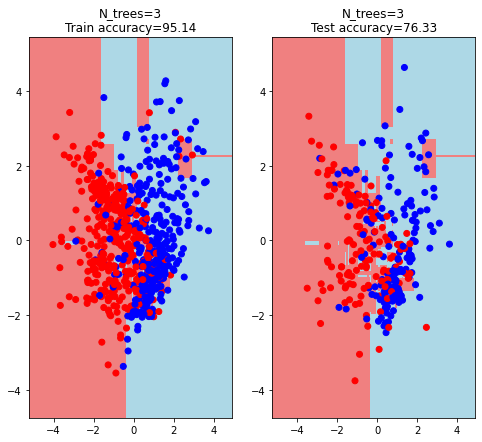

In [115]:
get_report(train_data, train_labels, test_data, test_labels, 3)

Построим лес из десяти деревьев

Точность случайного леса из 10 деревьев на обучающей выборке: 99.143
Точность случайного леса из 10 деревьев на тестовой выборке: 77.000


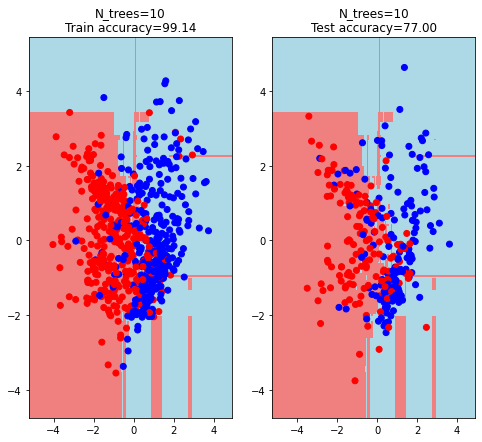

In [116]:
get_report(train_data, train_labels, test_data, test_labels, 10)

Построим лес из пятидесяти деревьев

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 80.333


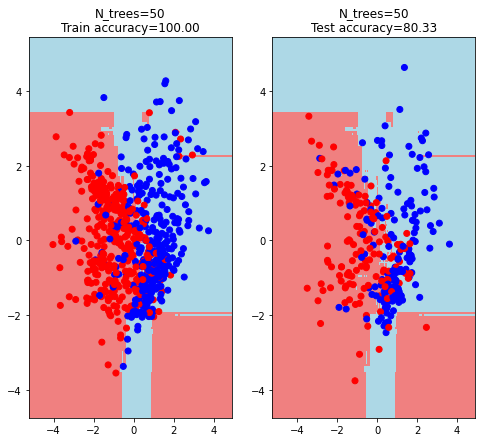

In [117]:
get_report(train_data, train_labels, test_data, test_labels, 50)

Построим лес из ста деревьев

Точность случайного леса из 100 деревьев на обучающей выборке: 100.000
Точность случайного леса из 100 деревьев на тестовой выборке: 79.333


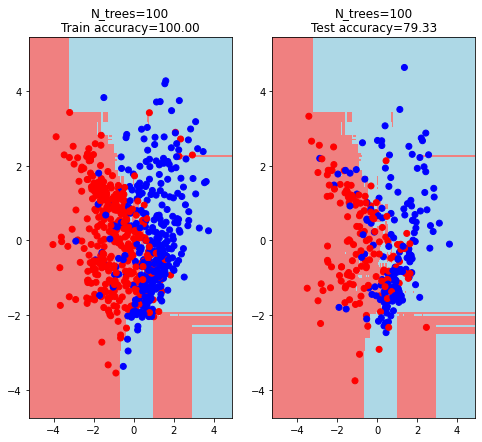

In [118]:
get_report(train_data, train_labels, test_data, test_labels, 100)

Построим лес из двухсот деревьев

Точность случайного леса из 200 деревьев на обучающей выборке: 100.000
Точность случайного леса из 200 деревьев на тестовой выборке: 79.333


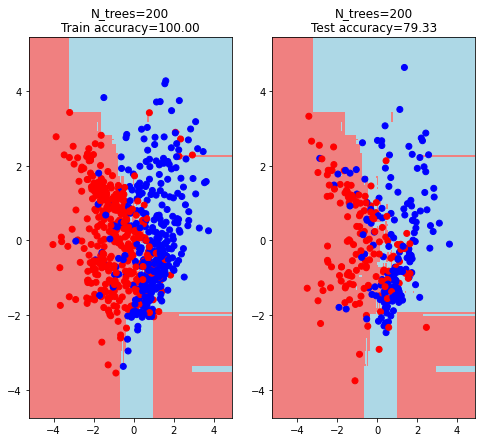

In [119]:
get_report(train_data, train_labels, test_data, test_labels, 200)

Сведем результаты в таблицу

In [120]:
report=pd.DataFrame(GLOB, columns=['n_trees', 'train_accuracy','test_accuracy'])
report

,n_trees,train_accuracy,test_accuracy
0,1,90.714286,69.000000
1,3,95.142857,76.333333
2,10,99.142857,77.000000
3,50,100.000000,80.333333
4,100,100.000000,79.333333
5,200,100.000000,79.333333


Из результатов видно, что с увеличением числа деревьев модель не переобучается.

 При этом, по мере увеличения числа деревьев разделяющая гиперплоскость всё больше подстраивается под данные.